# En este código se genera un Pipeline, Grid Search, Random Search que revisa varias combinaciones de preprocesamiento y varios hiperparámetros del XGBoost.

In [4]:
### Luceth Argote & Santiago Cruz.

# Librerias a usar
from funciones import *

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

#Definimos un máximo de hilos a usar
""" os.environ["OMP_NUM_THREADS"] = "3"
cv2.setNumThreads(3)  """

' os.environ["OMP_NUM_THREADS"] = "3"\ncv2.setNumThreads(3)  '

In [5]:
ruta_imagenes = "../img"
clases = ['normal', 'grieta', 'hueco']

df = load_images(img_directorio_path=ruta_imagenes, classes=clases)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4445 entries, 0 to 4444
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   imagen color  4445 non-null   object
 1   imagen gris   4445 non-null   object
 2   clase         4445 non-null   object
dtypes: object(3)
memory usage: 104.3+ KB


No se tienen datos nulos y las columnas son del mismo tipo de dato.

### Graficamos algunas de las imágenes.

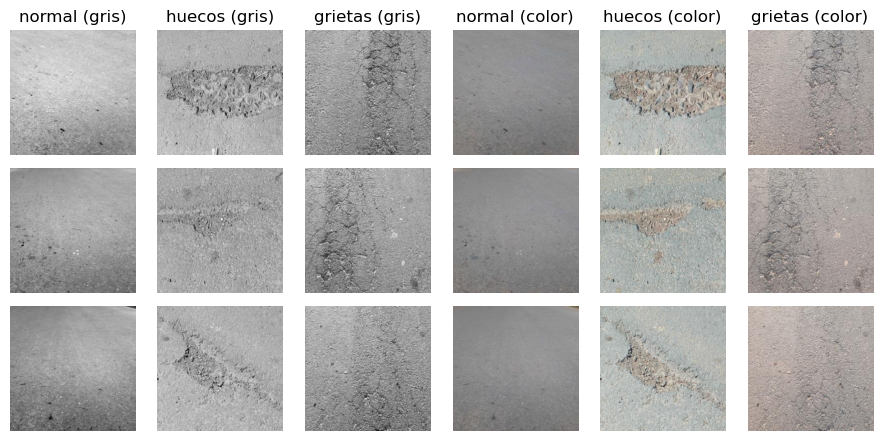

In [4]:

inicio = 200
final = inicio + 3
graficar = [
    df[df['clase']=='normal']['imagen gris'][inicio:final].tolist(),
    df[df['clase']=='hueco']['imagen gris'][inicio:final].tolist(),
    df[df['clase']=='grieta']['imagen gris'][inicio:final].tolist(),
    df[df['clase']=='normal']['imagen color'][inicio:final].tolist(),
    df[df['clase']=='hueco']['imagen color'][inicio:final].tolist(),
    df[df['clase']=='grieta']['imagen color'][inicio:final].tolist()
]

show_images(graficar, ['normal (gris)', 'huecos (gris)', 'grietas (gris)', 'normal (color)', 'huecos (color)', 'grietas (color)'], gray=True, size=1.5)

### Codificamos las clases (normal, grietas, huecos).

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['clase'] = le.fit_transform(df['clase'])

# Pipeline

Se usó ***xgboost***  porque es uno de los clasificadores más potentes y eficientes para trabajar con problemas multiclase, como en nuestro caso.

In [7]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('preproc', ImagePreprocessor()),
    ('bovw', BagOfVisualWords()),   # usa SIFT por defecto
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
                objective='multi:softprob',         # Para multiclase con probabilidades
                eval_metric='mlogloss',             # Buen métrico para multiclase
                tree_method='hist'                # Eficiente para CPU (rápido y preciso)
            )
    )
])

#Otros hiperparámetros que se pueden usar.
""" param_grid = {
    'preproc__brightness': [0.6 + i*0.1 for i in range(8)],
    'preproc__contrast': [2,6],
    'preproc__blur': [(0, 0), (3, 0)],
    'preproc__sobel': [0, 1, 3],
    'preproc__canny': [(0, 0), (100, 300)],
    'preproc__otsu': [False, True],
    'preproc__laplacian': [0, 3],

    'bovw__n_clusters': [3, 4, 6],
    'bovw__feature_detector': ['SIFT', 'ORB'],
    'bovw__max_descriptors': [500, 1000],

    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [3, 5, 7]
}
 """
#Hiperparámetros implementados.
param_grid = {
    'preproc__brightness': [1.2],
    'preproc__contrast': [6],
    'preproc__blur': [(3, 0)],
    'preproc__sobel': [0, 3],
    'preproc__canny': [(0, 0)],
    'preproc__otsu': [False],
    'preproc__laplacian': [0],

    'bovw__n_clusters': [3],
    'bovw__feature_detector': ['SIFT'],
    'bovw__max_descriptors': [1000],

    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [3, 5, 7]
}

In [7]:
import sklearn
import xgboost

print(f"scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

scikit-learn version: 1.5.2
XGBoost version: 2.1.1


# Grid Search y Randomized Search.

In [9]:
import random

# Generar semilla aleatoria
seed = random.randint(0, 10000)
print(f"Semilla usada para el shuffle: {seed}")

# Aplicar shuffle - Para que las imagenes queden de forma aleatoria.
df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)

Semilla usada para el shuffle: 6286


Grid Search explora todas las combinaciones posibles de hiperparámetros en una malla definida, mientras que Randomized Search selecciona combinaciones al azar dentro del espacio definido. Grid Search suele ser más costoso en tiempo de cómputo, pero puede ofrecer mejores resultados si el espacio de búsqueda no es muy grande. Aunque, Randomized Search suele ser más eficiente cuando el espacio es amplio o cuando algunos hiperparámetros tienen más impacto que otros.

In [9]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipeline,
                    param_grid,
                    scoring='f1_weighted',
                    cv=4,
                    verbose=2,
                    n_jobs = 3)

df_sample = df_shuffled.sample(frac=0.1, random_state=42)
print(df_sample.shape[0])


X_train, X_test, y_train, y_test = train_test_split(
    df_sample['imagen gris'], df_sample['clase'], test_size=0.3, random_state=42
)

# Ajustar sobre el conjunto de entrenamiento
grid.fit(X_train, y_train)

44
Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preproc', ImagePreprocessor()),
                                       ('bovw', BagOfVisualWords()),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss'...
             param_grid={'bovw__feature_detector': ['SIFT'],
                         'bovw__max_descriptors': [1000],
                         'bovw__n_clusters': [3],
                         'clf__learning_rate': [0.05, 0.1],
                         'clf__max_depth': [3, 5, 7],
                         'clf__n_estimators': [100, 200],
                         'preproc__blur': [(3, 0)],
                         'preproc__brightness': [1.2],
                         'preproc__canny': [(0, 0)], 'preproc__contrast': [6],
                         'preproc__laplacian': [0], 'preproc__otsu': [False],
                         'preproc__sobel': [0, 3]},
             scoring='f1_weighted', verbose=2)

El entrenamiento duró 20 minutos

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1_weighted',
    cv=4,
    verbose=2,
    n_jobs=-1,
    random_state=seed)

df_sample = df_shuffled.sample(frac=0.1, random_state=42)
print(df_sample.shape[0])

# Paso opcional pero recomendado: separar un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(
    df_shuffled['imagen gris'], df_shuffled['clase'], test_size=0.3, random_state=42
)

444


In [ ]:
# Ajustar sobre el conjunto de entrenamiento
random_search.fit(X_train, y_train)

El entrenamiento duró 30 minutos

In [2]:
import joblib

### Guardar el mejor modelo encontrado.

In [ ]:
joblib.dump(grid.best_estimator_, 'mejor_modelo_grid') #Para Grid Search

['mejor_modelo_grid']

In [ ]:
joblib.dump(random_search.best_estimator_, 'mejor_modelo_random') #Para Random Search

['mejor_modelo_random']

### Cargar el modelo guardado.

In [ ]:
print("Mejores parámetros encontrados (Grid Search):")
print(grid.best_params_)
print()

Mejores parámetros encontrados (Grid Search):
{'bovw__feature_detector': 'SIFT', 'bovw__max_descriptors': 1000, 'bovw__n_clusters': 3, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'preproc__blur': (3, 0), 'preproc__brightness': 1.2, 'preproc__canny': (0, 0), 'preproc__contrast': 6, 'preproc__laplacian': 0, 'preproc__otsu': False, 'preproc__sobel': 3}



In [ ]:
print("Mejores parámetros encontrados (Random Search):")
print(random_search.best_params_)
print()

Mejores parámetros encontrados (Random Search):
{'preproc__sobel': 3, 'preproc__otsu': False, 'preproc__laplacian': 0, 'preproc__contrast': 6, 'preproc__canny': (0, 0), 'preproc__brightness': 1.2, 'preproc__blur': (3, 0), 'clf__n_estimators': 100, 'clf__max_depth': 7, 'clf__learning_rate': 0.05, 'bovw__n_clusters': 3, 'bovw__max_descriptors': 1000, 'bovw__feature_detector': 'SIFT'}



In [ ]:
modelo_cargado = joblib.load('mejor_modelo_random')

## Predicción.

###  Predicción con el mejor modelo.

In [ ]:
y_pred = modelo_cargado.predict(X_test)

### Reporte de clasificación.

In [ ]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Reporte de clasificación:
              precision    recall  f1-score   support

      grieta       0.68      0.70      0.69      1024
       hueco       0.68      0.62      0.65      1028
      normal       0.83      0.89      0.86      1060

    accuracy                           0.74      3112
   macro avg       0.73      0.73      0.73      3112
weighted avg       0.73      0.74      0.73      3112



### Matriz de Confusión.

In [ ]:
from sklearn.metrics import confusion_matrix

print("Matriz de confusión")
print(confusion_matrix(y_test, y_pred))

Matriz de confusión
[[713 222  89]
 [289 636 103]
 [ 44  76 940]]


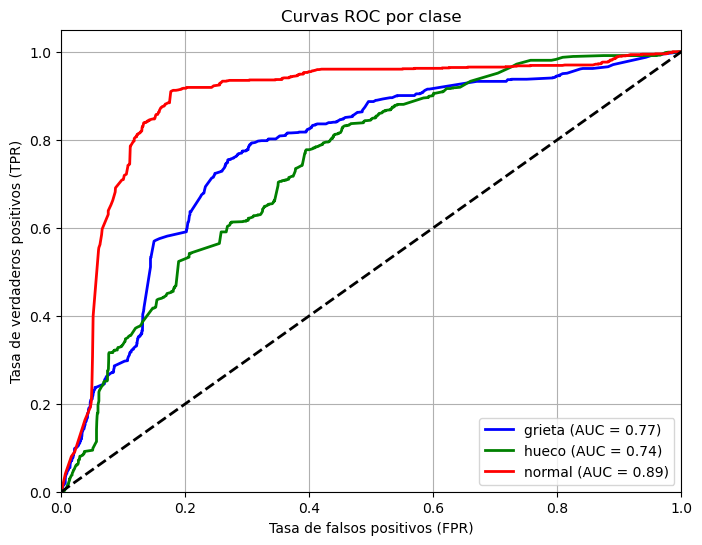

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Paso 1: Binarizamos usando los valores codificados
y_test_bin = label_binarize(y_test, classes=le.transform(le.classes_))
n_classes = y_test_bin.shape[1]

# Paso 2: Obtenemos probabilidades
y_score = modelo_cargado.predict_proba(X_test)

# Paso 3: Curvas ROC como antes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Paso 4: Graficar con los nombres originales de las clases
# target_names contiene los nombres originales de las clases
target_names = le.classes_

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

